###### 자동차 연비 예측하기

In [281]:
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.4.0-dev20200724


###### Auto MPG 데이터셋
    UCI 머신러닝 저장소에서 다운로드를 받자!

In [282]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/\
                                    machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/Users/wglee/.keras/datasets/auto-mpg.data'

In [283]:
# 데이터 불러오기
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepwer', 'Weight', 'Acceleration',\
               'Model_year', 'Origin']

dataset = pd.read_csv(dataset_path, names=column_names, na_values='?', comment='\t', sep=' ',\
                     skipinitialspace=True)
df = dataset.copy()

In [284]:
df.tail(2)

,MPG,Cylinders,Displacement,Horsepwer,Weight,Acceleration,Model_year,Origin
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [285]:
df['Origin'].unique()

array([1, 3, 2])

    null값 확인 결과 6개의 데이터가 누락된 것을 확인하였고 제거 정제 작업을 하였습니다.

In [286]:
df.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepwer       6
Weight          0
Acceleration    0
Model_year      0
Origin          0
dtype: int64

In [287]:
df.dropna(inplace=True)

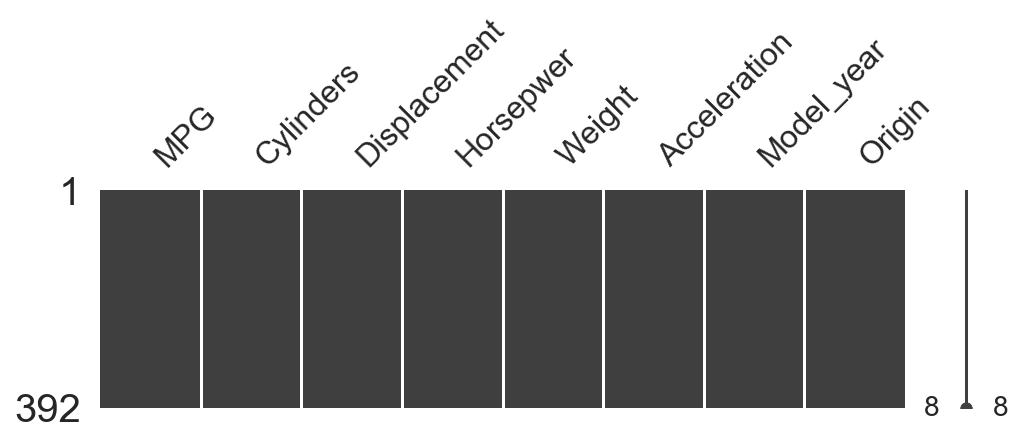

In [288]:
import missingno as msno
msno.matrix(df, figsize=(8, 2))

    "Origin" 열은 수치형이 아니고 범주형이므로 원-핫 인코딩(one-hot encoding)으로 변환

In [289]:
origin = df.pop('Origin')

In [290]:
df['USA'] = (origin == 1) * 1.0
df['Europe'] = (origin == 2) * 2.0
df['Japan'] = (origin == 3) * 3.0

In [291]:
df.tail(2)

,MPG,Cylinders,Displacement,Horsepwer,Weight,Acceleration,Model_year,USA,Europe,Japan
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


    데이터셋 분리 (train, test)

In [292]:
train_df = df.sample(frac=0.7, random_state=0)
test_df = df.drop(train_df.index)

In [293]:
len(train_df)

274

    데이터 EDA를 통해 데이터의 분포 및 통계치를 확인합니다

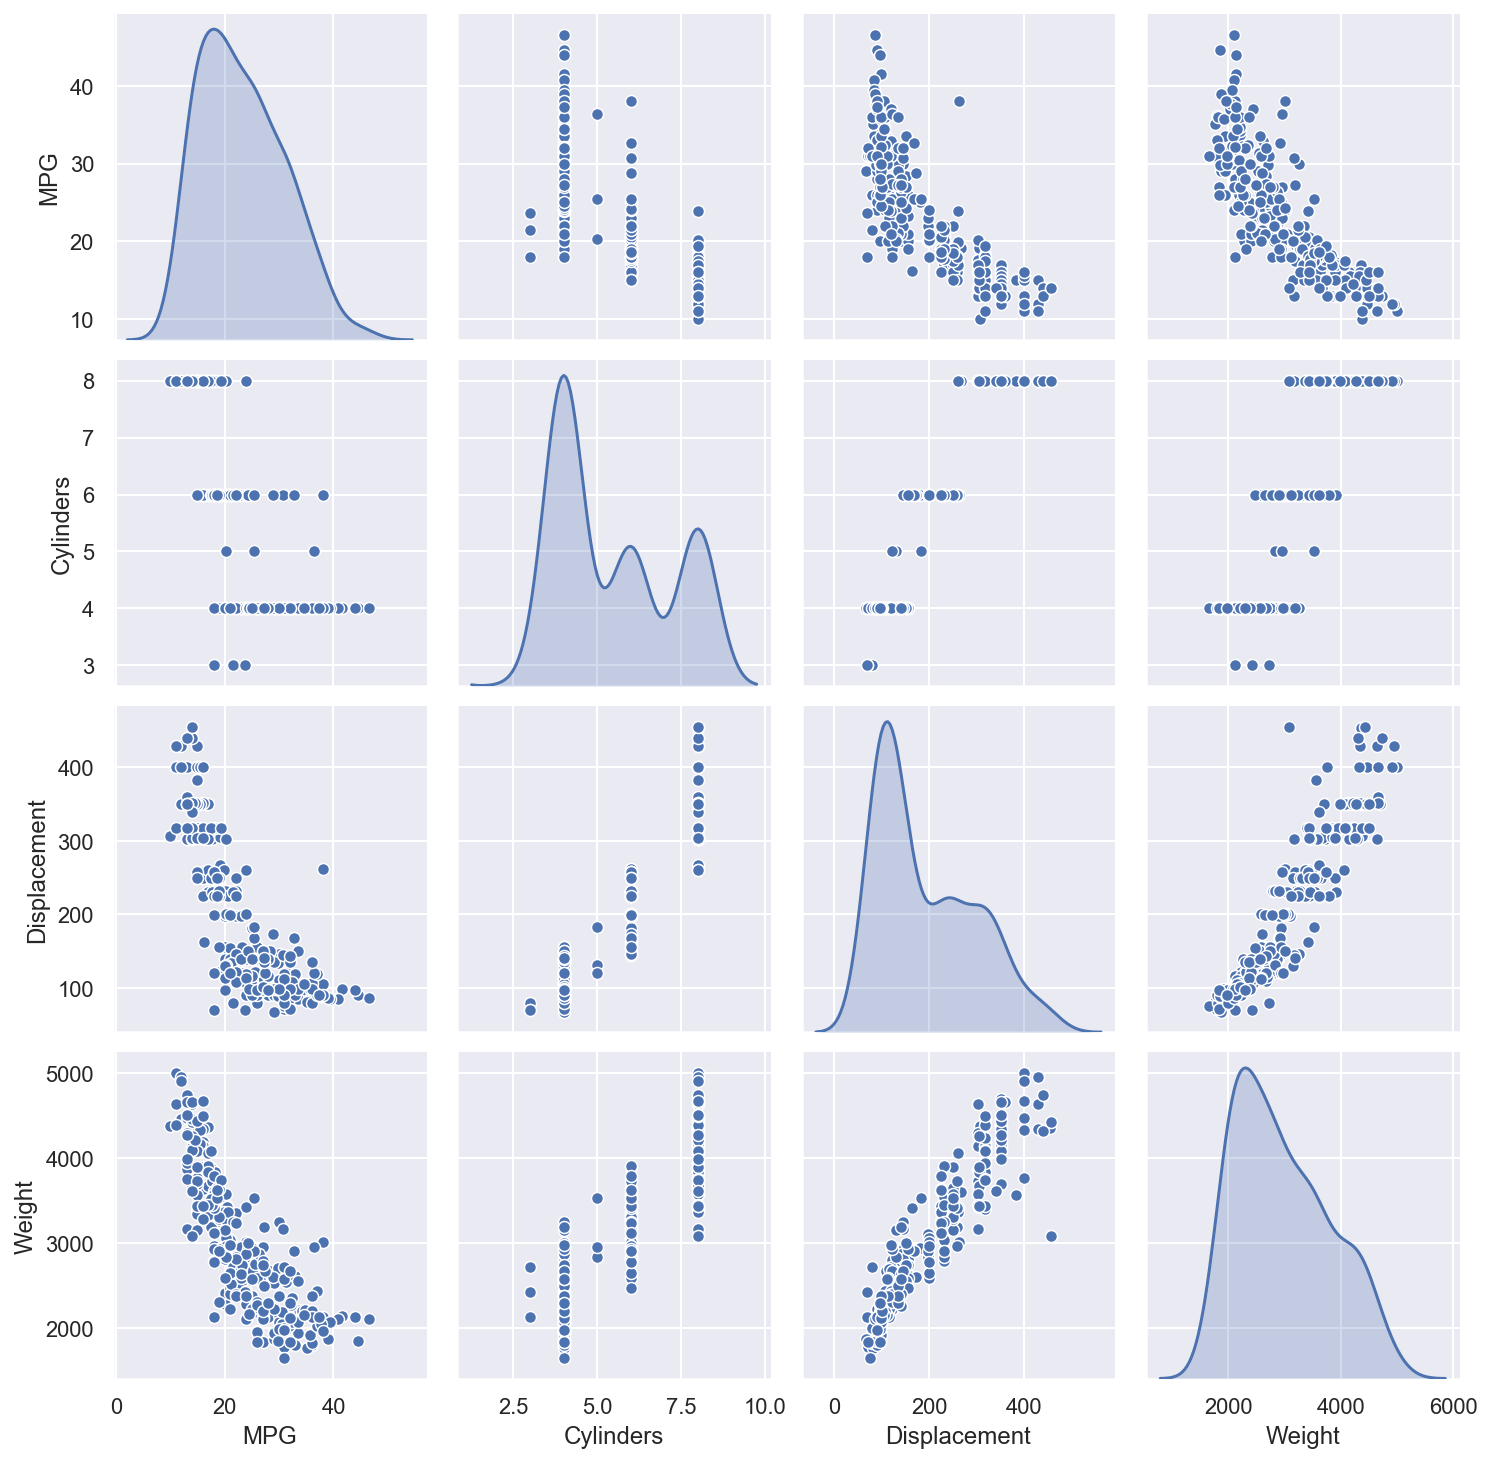

In [294]:
sns.pairplot(train_df[['MPG','Cylinders','Displacement','Weight']], diag_kind='kde')
plt.show()

In [295]:
train_stats = train_df.describe()
# train_stats.pop("MPG")
train_stats = train_stats.T #transpose
train_stats

,count,mean,std,min,25%,50%,75%,max
MPG,274.0,23.323358,7.643458,10.0,17.0,22.0,29.000,46.6
Cylinders,274.0,5.467153,1.690530,3.0,4.0,4.0,8.000,8.0
Displacement,274.0,193.846715,102.402201,68.0,105.0,151.0,260.000,455.0
Horsepwer,274.0,104.135036,37.281034,46.0,76.0,93.0,128.000,225.0
Weight,274.0,2976.879562,829.860536,1649.0,2250.5,2822.5,3573.000,4997.0
Acceleration,274.0,15.590876,2.714719,8.0,14.0,15.5,17.275,24.8
Model_year,274.0,75.934307,3.685839,70.0,73.0,76.0,79.000,82.0
USA,274.0,0.635036,0.482301,0.0,0.0,1.0,1.000,1.0
Europe,274.0,0.335766,0.748893,0.0,0.0,0.0,0.000,2.0
Japan,274.0,0.591241,1.195564,0.0,0.0,0.0,0.000,3.0


    이번에는 train, test 분리가 아니라 feature와 label를 분리시켜 줍니다.

In [296]:
train_labels = train_df['MPG']
test_labels = test_df['MPG']

###### 데이터 정규화
    feature의 크기와 범위가 다르면 정규화(normalization)를 하는 것이 권장됩니다. 정규화를 하지 않아도 모델링이 가능하지만 훈련시키기 어렵고 입력 단위에 의존적인 모델이 만들어지게 됩니다.

In [297]:
# # 데이터 정규화
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# train_df = scaler.fit_transform(train_df)
# test_df = scaler.fit_transform(test_df)

In [298]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_df)
normed_test_data = norm(test_df)

###### 모델링
    모델을 구성해 보죠. 여기에서는 두 개의 완전 연결(densely connected) 은닉층으로 Sequential 모델을 만들겠습니다. 출력 층은 하나의 연속적인 값을 반환합니다. 나중에 두 번째 모델을 만들기 쉽도록 build_model 함수로 모델 구성 단계를 감싸겠습니다.

In [316]:
# 모델링
def build_model():
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=[len(train_df.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [317]:
model = build_model()

###### 모델 확인
    .summary() 메서드를 사용하여 모델의 간단한 정보를 출력해줍니다.

In [318]:
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_46 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 65        
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_________________________________________________________________
None


    모델을 한번 실행해 보죠. training 세트에서 10개의 샘플을 하나의 배치로 만들어 model_predict 메서드를 호출해 보겠습니다.

In [319]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.03285253],
       [-0.01362434],
       [-0.48285854],
       [ 0.01581845],
       [ 0.08219826],
       [ 0.08362657],
       [ 0.15519306],
       [ 0.28581452],
       [ 0.07680693],
       [ 0.01200353]], dtype=float32)

###### 모델 훈련
    에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다.

In [320]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

    acc : 훈련 정확도
    loss : 훈련 손실값
    val_acc : 검증 정확도
    val_loss : 검증 손실값


In [315]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,accuracy,val_loss,val_mae,val_mse,val_accuracy,epoch
995,0.102436,0.234032,0.102436,0.0,0.165683,0.324213,0.165683,0.0,995
996,0.124358,0.292103,0.124358,0.0,0.263786,0.404004,0.263786,0.0,996
997,0.130789,0.295300,0.130789,0.0,0.212862,0.362374,0.212862,0.0,997
998,0.116644,0.275093,0.116644,0.0,0.054454,0.196261,0.054454,0.0,998
999,0.106241,0.280440,0.106241,0.0,0.121306,0.281089,0.121306,0.0,999


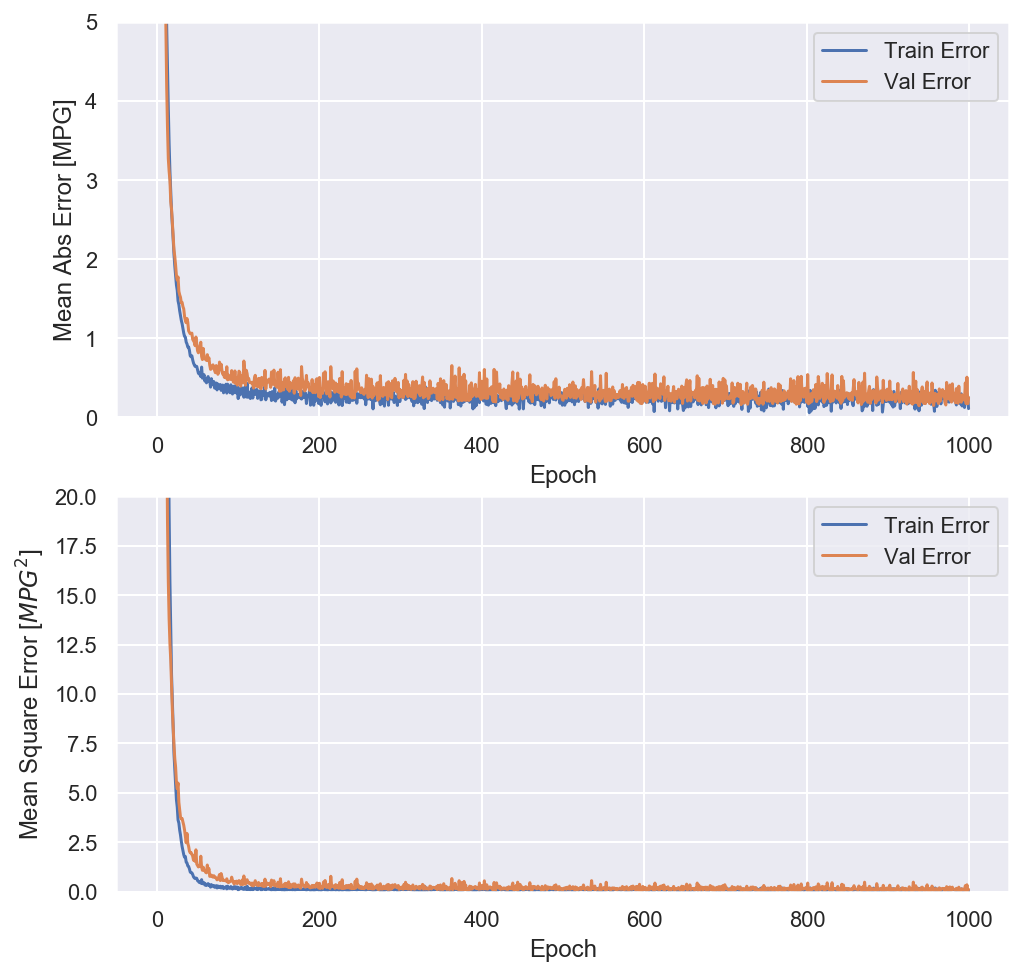

In [305]:
def plot_history(history):
       
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,8))
    
    plt.subplot(2,1,1)
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['val_mae'],
             label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
             label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

plot_history(history)


......................................................................................

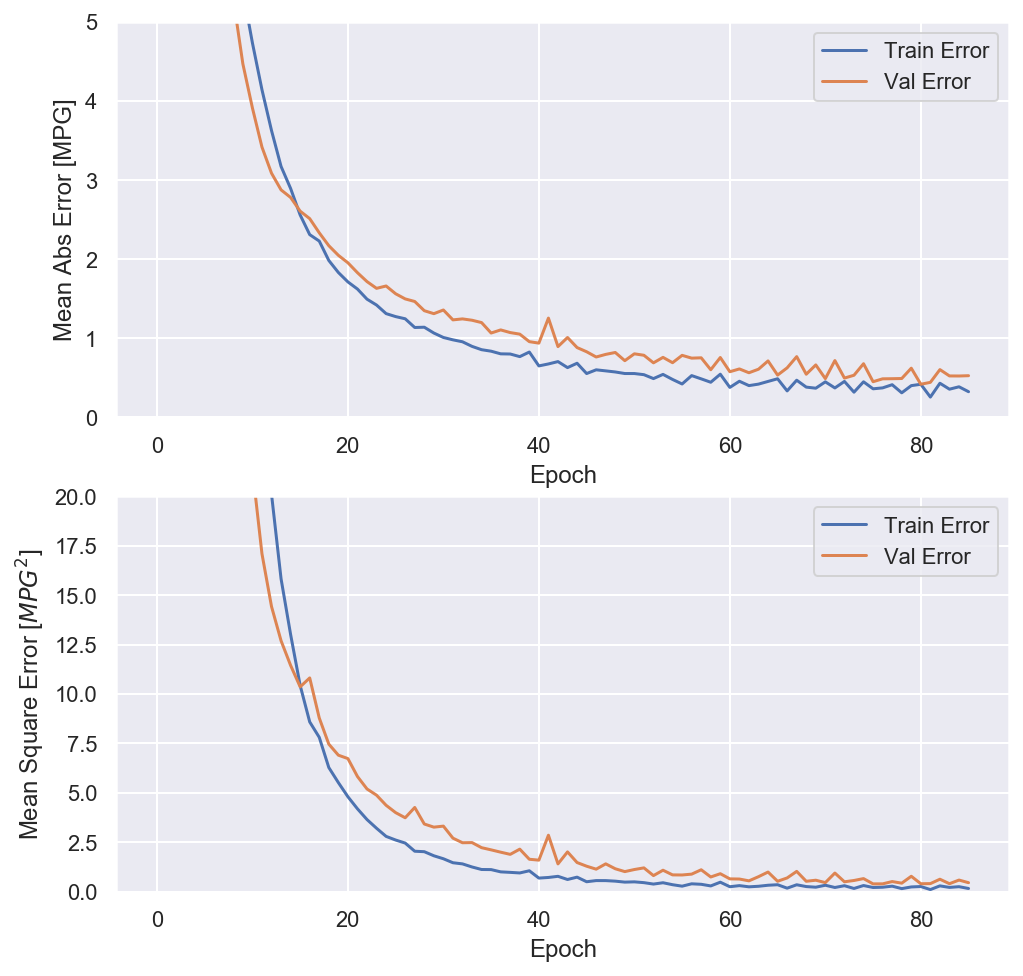

In [306]:
model = build_model()

# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

###### 모델 검증
    테스트 세트의 모델 성능을 확인

In [307]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

4/4 - 0s - loss: 0.4875 - mae: 0.5579 - mse: 0.4875
테스트 세트의 평균 절대 오차:  0.56 MPG


###### 예측
    테스트 세트에 있는 샘플을 이용해 MPG 값 예측

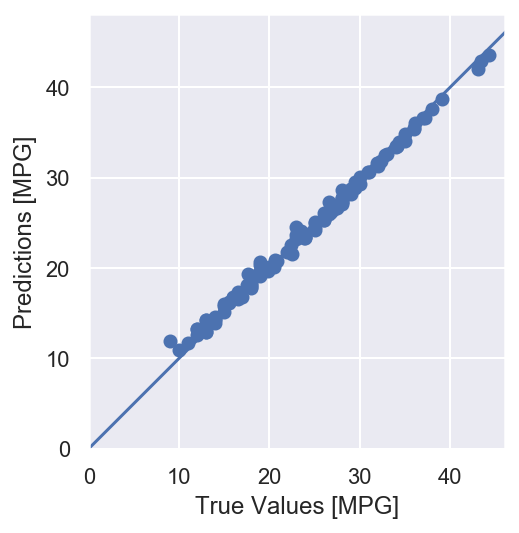

In [308]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

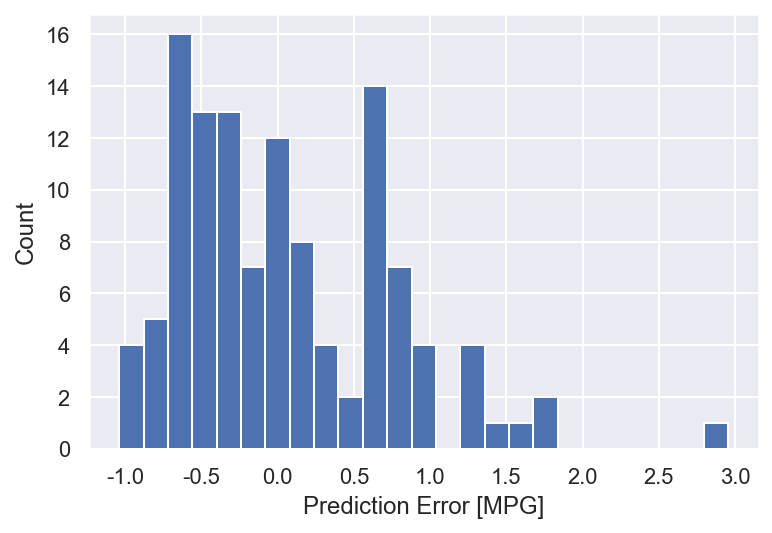

In [309]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")